# INTRODUCTION
This notebook contains workflow to annotating cell types in Xenium liver cancer dataset with label Transfer. The notebook is hugely based on analysis guides provided by 10X Genomics on the following website:
https://www.10xgenomics.com/analysis-guides/xenium-cell-type-annotation. While the 10X Genomics' analysis guides is completely Seurat and R-based, here we will implement the same steps but using anndata object. For what packages are needed please go to the bottom of the page to see sessionInfo. First we need to create an anndata object to feed the dataset into scanpy tools since the liver cancer dataset comes in zarr format and scanpy does not have direct zarr reader utility for reading and writing (or at least I got into error and error while implementing theirs). To learn how to read zarr files, please visit zarr https://www.10xgenomics.com/support/software/xenium-onboard-analysis/latest/advanced/example-code or simply python documentation of zarr at https://zarr.readthedocs.io/en/stable/user-guide/arrays.html. I have written some classes and helper functions to facilitate this workflow which may be integrated in scanpy. In a nutshell, I have written a feature_matrix_loader.py script which has methods to load either cell by feature (NOTE: not cell by gene; a feature may not just be a gene expression) or feature by cell which can be used to construct anndata object to further pass as an argument to scanpy. To learn about anndata object please visit: https://anndata.readthedocs.io/en/stable/. Another useful script is cell_stat_loader.py, which has methods to obtain several spatial information about cells on individual level like the centroid position of the cell, nucleus centroid position, cell segmentation/boundaries/polygons etc. The documentation about both these scripts can be found in documents/ directory. 

To run this notebook, I have already created the anndata object as h5ad object for liver cancer dataset. To learn how such file was created please look into `create_ann_data.ipynb`.

In [8]:
%load_ext autoreload
%autoreload 2

# set up project path
import os, sys, warnings, json, tqdm, subprocess
project_path = os.path.join(os.path.expanduser("~"), 'xenium_liver_cancer')
sys.path.append(project_path)
warnings.simplefilter(action="ignore", category=Warning)

# Generic libraries
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.sparse import issparse
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from scipy.stats import linregress, median_abs_deviation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.1 Choose a scRNA-seq reference dataset (COPIED FROM 10X GENOMICS)
Choosing an appropriate single cell reference dataset is a critical first step that will influence the quality of the transferred labels. This reference can be a single sample that you annotated manually before, or it can be a published and ideally a curated existing reference.

**What to consider when choosing your reference:**

- Is it a matched sample type? Consider matching both biological factors (tissue type, age/sex/ancestry, disease state, treatments, etc.) and technical factors (sequencing technology, FF or FFPE, whole-cell versus single nuclei).
- The reference should ideally be balanced for different cell types based on your tissue type and region. For example, a single cell reference generated from the hippocampus may not translate well to cortex data. When using public data, integrated references generated from more than one sample tend to improve reference mapping (Mölbert et al.).
- Is the reference dataset curated with confident annotations? Consider which methods were used to annotate the cell types in the reference, the sample size and number of cells in the dataset, the sequencing depth of the experiment, and whether any validation was performed.

**Recommended single cell reference sources**

There are numerous publicly available and well-documented single cell reference datasets and atlases, such as:

- Tabula Muris
- Tabula Sapiens
- CELLxGENE
- EMBL-EBI Single Cell Expression Atlas

#### 1.1.1 referece dataset selection:
Regadring first question, We select the liver dataset from Tabula Sapeins as reference dataset. To download it please follow following browsing sequence:
https://tabula-sapiens.sf.czbiohub.org/-> (Data Access) -> (Processed data available from figshare/Tabula Sapiens on figshare/Access the data) -> (select the liver data) -> Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad

or simply do `wget --content-disposition https://figshare.com/ndownloader/files/50851056 in the working directory. 

Then we load the reference dataset as ref_obj using scanpy since it is already a readable via scanpy.


In [10]:
ref_obj = sc.read_h5ad(f'{project_path}/Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad')
ref_obj.var['ensembl_id'] = ref_obj.var['ensembl_id'].str.replace(r'\.\d+', '', regex=True)
ref_obj

AnnData object with n_obs × n_vars = 22214 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors', 'leide

In [11]:
ref_obj_original = ref_obj.copy()

In [12]:
# We will only select the dataset that came from 10X platform
ref_obj = ref_obj[ref_obj.obs['method'] == '10X']
# We will only select the cells that has been manually verified by tissue expert to be the corresponding cell type.
ref_obj = ref_obj[ref_obj.obs['manually_annotated'] == 'True']
ref_obj

View of AnnData object with n_obs × n_vars = 9855 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors',

#### 1.1.2 Cell types in the reference object
Regarding different cell types in reference dataset, we see that there are 20 different cell types with macrophages and hepatocytes almost equal in counts, together occupying 37%, monocyte 16% and 10% by endothelial cells. While the reference dataset does not seem balanced in all the cell types, we will come to how to create a balanced dataset later on. But for now we will simply proceed with what we have. Note: Had we not filtered out the unverified cell types, we would have ended up with 70% hepatocytes. The dataset we have now seems more appropriate dataset for referencing our cancer dataset as the reference dataset itself seems to represent diseased dataset now.

cell_types                  
macrophage                      1877
hepatocyte                      1809
monocyte                        1584
endothelial cell                1045
t cell                           945
erythrocyte                      705
intrahepatic cholangiocyte       400
plasma cell                      336
natural killer cell              272
mature nk t cell                 227
hepatic stellate cell            177
b cell                           105
nk t cell                         99
neutrophil                        71
pre-natural killer cell           71
fibroblast                        69
dendritic cell                    38
hematopoietic precursor cell      19
mast cell                          4
classical monocyte                 2
Name: count, dtype: int64


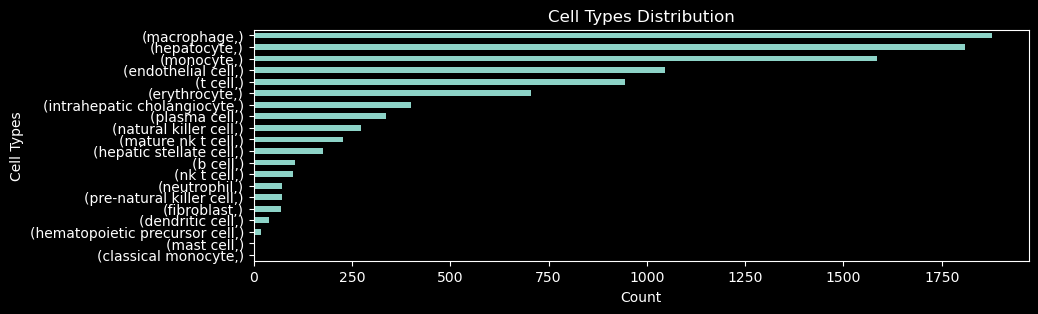

In [13]:
cell_type_counts = pd.DataFrame({'cell_types': ref_obj.obs['free_annotation']}).value_counts()
print(cell_type_counts)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
cell_type_counts = cell_type_counts.sort_values(ascending=False)
colors = plt.cm.cividis_r(np.linspace(0.2, 0.8, len(cell_type_counts)))
cell_type_counts.plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_ylabel('Cell Types')
ax.set_title('Cell Types Distribution')
plt.show()

#### 1.1.3 QC and filtering of ref dataset
We will further perform some QC and filter out cells. First we plot three observation features: n_genes_by_counts, total_counts, and pct_counts_mt.

n_genes_by_counts -> Count of different genes that expressed. Has non-zero value in `.X` matrix along `axis=1`.

total_counts -> Total count of the genes that expressed. Sum of non-zero value in `.X` matrix along `axis=1`

pct_counts_mt -> Percentage of mitochondrial genes that expressed among genes that expressed. To see how many genes are mitochondrial, check out    `ref_obj.var['mt'].value_counts()`.

We can print a generic statistic of these three variables and plot them for visual inspections as follows:

In [14]:
obs_variables = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
ref_obj.obs[obs_variables].describe()

,n_genes_by_counts,total_counts,pct_counts_mt
count,9855.000000,9855.000000,9855.000000
mean,2769.281684,10111.371487,16.391269
std,1291.506802,7019.913540,8.048052
min,370.000000,2792.000000,0.347399
25%,1843.000000,5428.500000,11.042725
50%,2528.000000,7817.000000,16.034066
75%,3577.500000,12802.000000,22.066421
max,10628.000000,88390.000000,50.362250


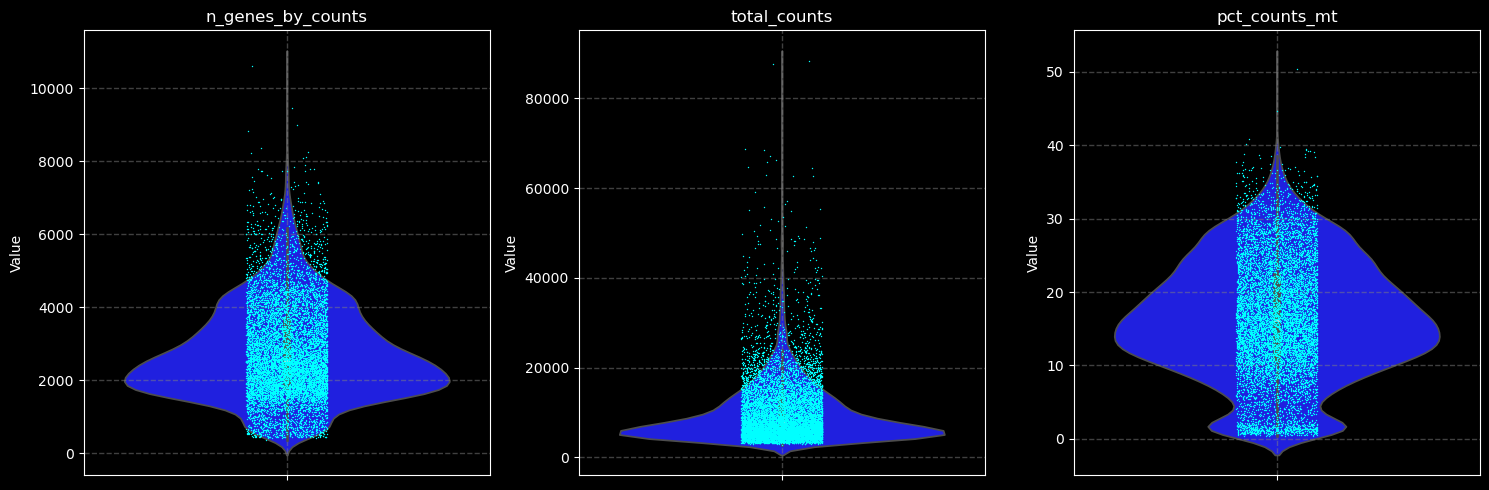

In [15]:
plot_variables = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
fig, axes = plt.subplots(nrows=1, ncols=len(plot_variables), figsize=(15, 5))
fig.patch.set_facecolor('black')
# Prepare data for seaborn violin plot
for i, variable in enumerate(plot_variables):
    ax = axes[i]
    plot_df = pd.DataFrame(ref_obj.obs[f'{variable}'])
    sns.violinplot(y=f'{variable}', data=plot_df, color='blue', ax=ax)
    sns.stripplot(y=f'{variable}', data=plot_df, ax=ax, color='cyan', size=1, jitter=True)
    ax.set_ylabel('Value')
    ax.set_xlabel('')
    ax.set_title(f'{variable}')
    ax.grid(True, color='gray', linestyle='--', linewidth=1., alpha=0.5)
plt.tight_layout()
plt.show()


As you can see, the minimum `n_genes_by_counts` is `370` which is great. So, we won't filter out any cells based on this metric. However, from the `pct_counts_mt` plot we see that there are a lot of cells that express more than `10%` mitochondrial genes. While we could restrict to have This is in contradiction to what I understand. If you check the fraction of genes that has been labelled mitochondrial from `var` key `mt` i.e. `((sum(ref_obj.var['mt'])/ref_obj.shape[1])*100)`, it shows only 0.06% of the genes are mitochondrial. Ah, I see. We were looking the counts of genes that were tagged/labelled mitochondrial which is obviously different than the number of mitochondrial genes. We can do a sanity check. Lets take the first cell meaning the first row. Only output the gene counts corresponding to 'mt' and sum them. That should equal to ref_obj.obs['total_counts_mt'][0] which is `199`. And indeed `np.sum(ref_obj.layers['raw_counts'].todense()[0, ref_obj.var['mt']])` results in `199`. I decided to restrict to cells which has less than `15%` mitochondrial gene counts.

In [16]:
ref_obj = ref_obj[ref_obj.obs['pct_counts_mt'] < 30]
ref_obj

View of AnnData object with n_obs × n_vars = 9410 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors',

We can see that we have now restricted to only 9410 cells. So, far we have not done any filtering on genes. We will focus on filtering out possible low-quality genes that do not express in any cells at all.
We can do so by investigating the `n_cells_by_counts` variable which is plotted below. We can see that a lot of cells do not express any genes at all.

-------FINAL CELL TYPES IN REFERENCE DATASET-------
cell_types                  
macrophage                      1856
hepatocyte                      1700
monocyte                        1556
endothelial cell                1028
t cell                           854
erythrocyte                      655
intrahepatic cholangiocyte       384
plasma cell                      316
natural killer cell              244
mature nk t cell                 201
hepatic stellate cell            170
b cell                            98
nk t cell                         98
pre-natural killer cell           71
fibroblast                        69
neutrophil                        49
dendritic cell                    36
hematopoietic precursor cell      19
mast cell                          4
classical monocyte                 2
Name: count, dtype: int64


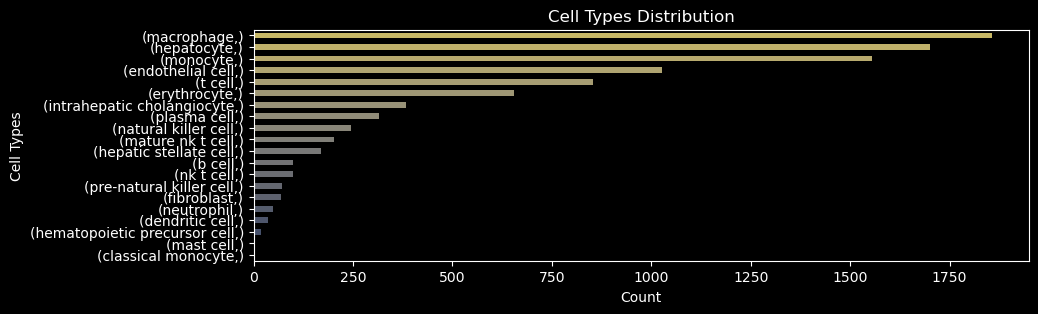

In [17]:
# Now lets see again the various cell types in the reference dataset.
print(f'-------FINAL CELL TYPES IN REFERENCE DATASET-------')
cell_type_counts = pd.DataFrame({'cell_types': ref_obj.obs['free_annotation']}).value_counts()
print(cell_type_counts)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
cell_type_counts = cell_type_counts.sort_values(ascending=False)
colors = plt.cm.cividis_r(np.linspace(0.2, 0.8, len(cell_type_counts)))
cell_type_counts.plot(kind='barh', ax=ax, color=colors)
ax.invert_yaxis()
ax.set_xlabel('Count', color='white')
ax.set_ylabel('Cell Types', color='white')
ax.set_title('Cell Types Distribution', color='white')
plt.show()

**So far so good! Now we will focus on loading the liver cancer dataset and perform QC and filtering.**

## 2. Liver Cancer Dataset

In [18]:
xenium_obj = ad.read_h5ad('liver_cancer.h5ad')
xenium_obj

AnnData object with n_obs × n_vars = 162628 × 474
    obs: 'cell_id_in_hex', 'cell_id_in_int', 'cell_area', 'nucleus_area', 'total_transcripts'
    var: 'ensembl_id', 'gene_symbol'
    obsm: 'cell_location', 'nucleus_location'
    layers: 'raw_counts'

#### 2.1 Liver cancer dataset QC and evaluation

In [19]:
# We may calculate some of the QC metrics using scanpy's calculate_qc_metrics which will add additional keys in obs and var regarding QC.
sc.pp.calculate_qc_metrics(xenium_obj, log1p=True, percent_top=[20, 50, 100], inplace=True)
xenium_obj

AnnData object with n_obs × n_vars = 162628 × 474
    obs: 'cell_id_in_hex', 'cell_id_in_int', 'cell_area', 'nucleus_area', 'total_transcripts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes'
    var: 'ensembl_id', 'gene_symbol', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'cell_location', 'nucleus_location'
    layers: 'raw_counts'

We may print some relevant statistics here. Note that we already had the total_transcripts information per cell which should match the total_counts calculated and indeed it matches.


,cell_area,nucleus_area,total_transcripts,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes
count,162628.000000,162628.000000,162628.000000,162628.000000,162628.000000,162628.000000,162628.000000,162626.000000,162626.000000,162626.000000
mean,153.603372,31.360562,129.561847,60.069963,4.033212,129.561847,4.674702,63.479752,91.591196,99.893899
std,102.668634,19.422442,80.084339,22.000934,0.428390,80.084339,0.668823,11.326142,7.832773,0.687183
min,3.793125,3.251250,0.000000,0.000000,0.000000,0.000000,0.000000,35.593220,61.016949,86.760563
25%,83.674534,17.023907,71.000000,44.000000,3.806662,71.000000,4.276666,56.118458,85.483871,100.000000
50%,130.546723,26.958282,114.000000,60.000000,4.110874,114.000000,4.744932,61.946903,91.836735,100.000000
75%,195.887820,41.588908,171.000000,75.000000,4.330733,171.000000,5.147494,68.181818,100.000000,100.000000
max,1350.262237,320.293293,1082.000000,162.000000,5.093750,1082.000000,6.987490,100.000000,100.000000,100.000000


As we can see from below that the minimum value of total_counts is 0 meaning there are cells which do not express any genes. We will filter out those cells.
Similarly, the highest counts in a cell is 1082. While this probably is not much I will plot histograms to aid for filtering.
And we see that there are rarely few cells that have high gene counts. We may simply restrict our data to less than 500 transcripts per cell.
Also, we could remove all cells that hav less than 10 transcripts.


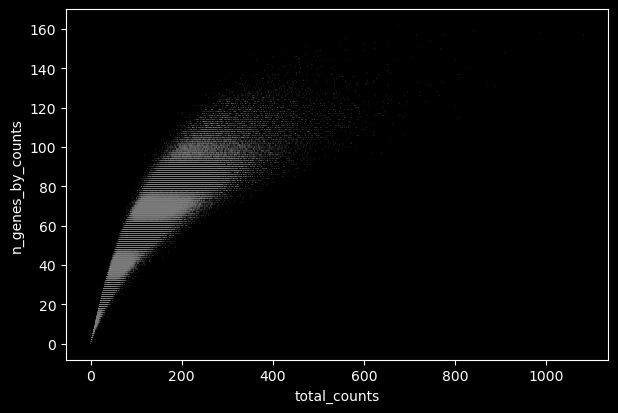

In [20]:
print('We may print some relevant statistics here. Note that we already had the total_transcripts information per cell which should match the total_counts calculated and indeed it matches.')
display(xenium_obj.obs.describe())
print('As we can see from below that the minimum value of total_counts is 0 meaning there are cells which do not express any genes. We will filter out those cells.')
print('Similarly, the highest counts in a cell is 1082. While this probably is not much I will plot histograms to aid for filtering.')
print('And we see that there are rarely few cells that have high gene counts. We may simply restrict our data to less than 500 transcripts per cell.')
print('Also, we could remove all cells that hav less than 10 transcripts.')
sc.pl.scatter(xenium_obj, "total_counts", "n_genes_by_counts")

But we will follow guide from single cell best practices: https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

In [21]:
def is_outlier(adata, metric: str, nmads: int):
    values = adata.obs[metric]
    median_val = np.median(values)
    mad_val = median_abs_deviation(values, scale='normal')
    outliers = (values < median_val - nmads * mad_val) | (values > median_val + nmads * mad_val)
    return outliers

xenium_obj.obs["outlier"] = (
    is_outlier(xenium_obj, "log1p_total_counts", 5)
    | is_outlier(xenium_obj, "log1p_n_genes_by_counts", 5)
    | is_outlier(xenium_obj, "pct_counts_in_top_20_genes", 5)
)
print(f'{xenium_obj.obs.outlier.value_counts()}')

#Lets check if there are any mitochondrial genes.
mito_ensembl_ids = sc.queries.mitochondrial_genes(
    "hsapiens", attrname="ensembl_gene_id"
)
xenium_obj.var["mt"] = xenium_obj.var['ensembl_id'].isin(mito_ensembl_ids['ensembl_gene_id'].values)
print("Mitochondrial genes if any\n=====================")
print(xenium_obj.var['mt'].value_counts())
print('Since there are none, there is no need to sweat on mito genes.')

# print(f"Total number of cells: {xenium_obj.n_obs}")
# xenium_obj = xenium_obj[(~xenium_obj.obs.outlier)].copy()

# print(f"Number of cells after filtering of low quality cells: {xenium_obj.n_obs}")

outlier
False    162170
True        458
Name: count, dtype: int64
Mitochondrial genes if any
mt
False    474
Name: count, dtype: int64
Since there are none, there is no need to sweat on mito genes.


We did not remove cells but only marked them.

# 3. Cell annotation:

#### 3.1 COMMON GENES BETWEEN TWO DATASETS

In [22]:
# **GREAT**. Lets now see how many genes are common between the reference dataset and the xenium dataset.
# Since the ensembl ids do not tend to change over time, while the gene_symbols might change, we will use ensembl ids to find the common genes.
#First we will do some sanity checks on the strings of ensembl ids saved for these datasets
print('-----REFERENNCE DATASET-------')
print(((ref_obj.var['ensembl_id']).apply(lambda x: 'mixed' if any(c.isupper() for c in x) and any(c.islower() for c in x) else 'uppercase' if any(c.isupper() for c in x) else 'lowercase' if any(c.islower() for c in x) else 'none')).value_counts())
print('-----XENIUM DATASET-------')
print(((xenium_obj.var['ensembl_id']).apply(lambda x: 'mixed' if any(c.isupper() for c in x) and any(c.islower() for c in x) else 'uppercase' if any(c.isupper() for c in x) else 'lowercase' if any(c.islower() for c in x) else 'none')).value_counts())
print('Good! Both the datasets have ensembl ids in uppercase format. So we should not have problem comparing them.\nWe could have also lowered these strings to ensure proper comparison, but since they are already in uppercase, we can skip that step.')
#Now lets find the common genes between the two datasets. Ther are various ways to do it.
# But since we might need the indices of the common genes for future purposes, we will use np.intersect1d with return_indices=True.
common_genes, common_gidx_ref, common_gidx_xenium  = np.intersect1d(ref_obj.var['ensembl_id'], xenium_obj.var['ensembl_id'], return_indices=True)
print(f'The number of common genes between the reference dataset and the xenium dataset is {len(common_genes)}.')
print('So almost all of the genes in the xenium dataset are present in the reference dataset.')

-----REFERENNCE DATASET-------
ensembl_id
uppercase    61806
Name: count, dtype: int64
-----XENIUM DATASET-------
ensembl_id
uppercase    474
Name: count, dtype: int64
Good! Both the datasets have ensembl ids in uppercase format. So we should not have problem comparing them.
We could have also lowered these strings to ensure proper comparison, but since they are already in uppercase, we can skip that step.
The number of common genes between the reference dataset and the xenium dataset is 473.
So almost all of the genes in the xenium dataset are present in the reference dataset.


**Lets now evaluate the gene expression correlation between the two datasets.**
We will define the same get_gex_means function as in the analysis guide.

In [23]:
def get_gex_means(xenium_obj, ref_obj):
    # Calculate mean counts for Xenium
    xen_means = pd.DataFrame({
        "mean_counts": xenium_obj.layers['raw_counts'].mean(axis=0).tolist()[0],
        "gene": xenium_obj.var['ensembl_id']
    }).sort_values(by="mean_counts", ascending=False)
    xen_means["Rank"] = range(1, len(xen_means) + 1)

    # Calculate mean counts for reference
    ref_means = pd.DataFrame({
        "mean_counts": ref_obj.layers['raw_counts'].mean(axis=0).tolist()[0],
        "gene": ref_obj.var['ensembl_id']
    }).sort_values(by="mean_counts", ascending=False)
    ref_means["Rank"] = range(1, len(ref_means) + 1)

    # Merge on gene
    merged_means = pd.merge(xen_means, ref_means, on="gene", how="left", suffixes=('_xenium', '_ref'))

    return merged_means


In [24]:
# Load gene panel JSON
with open(f"{project_path}/xenium_data/diseased/gene_panel.json", "r") as f:
    gene_panel = json.load(f)

# Extract targets
targets = gene_panel["payload"]["targets"]

# Create panel_source DataFrame
panel_source = pd.DataFrame({
    "gene_panel": [t["source"]["identity"]["name"] for t in targets],
    "gene": [t["type"]["data"].get('id', np.nan) for t in targets]
})

# Get merged means
merged_means = get_gex_means(xenium_obj, ref_obj)

# Merge with panel_source
merged_means = pd.merge(panel_source, merged_means, on="gene", how="left")

In [25]:
merged_means.head()

,gene_panel,gene,mean_counts_xenium,Rank_xenium,mean_counts_ref,Rank_ref
0,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000072110,0.888666,38.0,1.017747,1650.0
1,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000196139,0.550145,60.0,0.558874,3249.0
2,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000132965,0.053632,250.0,0.420616,4156.0
3,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000243480,0.054788,247.0,0.000106,40519.0
4,Xenium Human Multi-Tissue + Add-on Gene Expres...,ENSG00000138772,0.058127,240.0,0.115834,9396.0


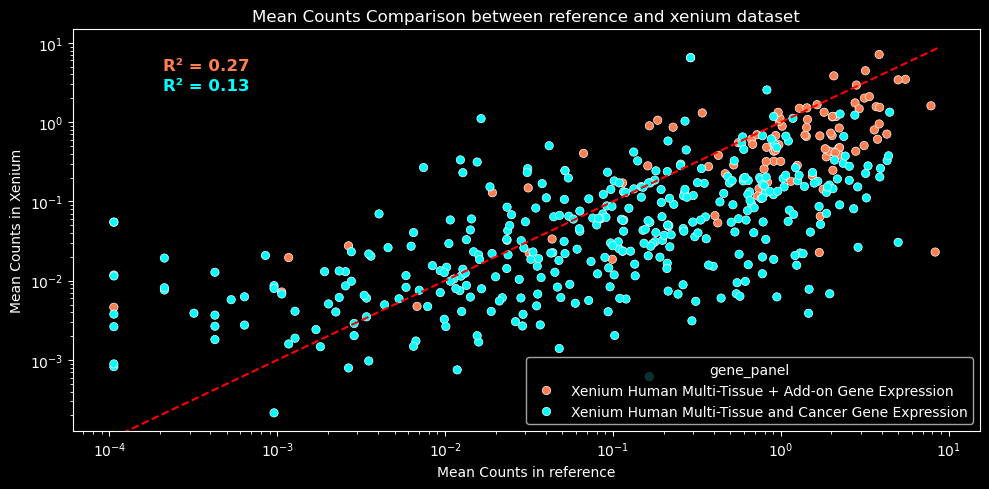

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define palette and plot scatter
palette = {
    f'{merged_means["gene_panel"].unique()[1]}': 'cyan',
    f'{merged_means["gene_panel"].unique()[0]}': 'coral'}
sns.scatterplot(data=merged_means, x='mean_counts_ref', y='mean_counts_xenium', hue='gene_panel', ax=ax, palette=palette)
#Note the mean counts came from raw counts, not log1p transformed data. 
# And note there are 3 genes from xenium dataset that are not in reference dataset for which when merging two dataframes must have given NaNs at rows for mean_counts_ref.
# There are additional NaNs from some of the genes not found in gene_panel json object.
# So lets avoid them.
merged_means_filtered = merged_means.dropna()

r2_results = {}
for group, panel in merged_means_filtered.groupby('gene_panel'):
    r2_results[group] = round(linregress(np.log1p(panel['mean_counts_ref']), np.log1p(panel['mean_counts_xenium'])).rvalue**2, 2)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xrange = np.linspace(xmin, xmax, 100)
ax.plot(xrange, xrange, color='red', linestyle='--', linewidth=1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean Counts in reference')
ax.set_ylabel('Mean Counts in Xenium')
ax.set_title('Mean Counts Comparison between reference and xenium dataset')

for i, (panel, r2) in enumerate(r2_results.items()):
    ax.text(
        0.1, 
        0.9-i*0.05,
        f'R² = {r2:.2f}',
        color=palette[panel],
        fontsize=12,
        weight='bold',
        transform = ax.transAxes
    )

plt.tight_layout()
plt.show()

Not so correlated but positive correlation at least. Possibly either we should further curate the reference, or find another reference or combine multiple references. But note that cell typing and annotation is a repetitive and rigorous task.

# 4. Cell typing and annotation following Xenium analysis guide style

We will run the steps in the guide in R. For that I have installed python and R in a conda environment. And alos the necessary modules. For what modules are required or used throughout the notebook go to SessionInfo at the end of the notebook

In [32]:
import time
import subprocess
from scipy.io import mmwrite

start = time.time()

# Subset matrices by common genes, make sure the rows are aligned for same order of genes in both dataset.
# Then save transpose as sparse matrix files (.mtx)
# Convert to float32 before saving to avoid uint type issues in R
xenium_mat = xenium_obj.X[:, common_gidx_xenium].astype(np.float32)
xenium_cell_ids_r = 'c(' + ', '.join(f'"{x}"' for x in xenium_obj.obs['cell_id_in_int'].values) + ')' #Note that we did not filter out any cells from the cancer dataset.
ref_mat = ref_obj.X[:, common_gidx_ref].astype(np.float32)

query_data_path = "query_data_mat.mtx"
ref_data_path = "ref_data_mat.mtx"
mmwrite(query_data_path, xenium_mat.T)
mmwrite(ref_data_path, ref_mat.T)

# Prepare R vector of reference labels
ref_labels_r = 'c(' + ', '.join(f'"{x}"' for x in ref_obj.obs['free_annotation'].values) + ')'

# Path for temporary R script and output
r_script_path = "run_seurat_tmp.R"

# R script contents with inline progress printing
r_script = f"""
set.seed(123)
cat("Loading libraries...\\n")
library(Seurat)
library(Matrix)

cat("Loading query data...\\n")
query_data <- readMM("query_data_mat.mtx")

cat("Creating Seurat object...\\n")
query_seurat_obj <- CreateSeuratObject(counts = query_data)

cat("Running Seurat pipeline...\\n")
query_seurat_obj <- NormalizeData(query_seurat_obj)
query_seurat_obj <- FindVariableFeatures(query_seurat_obj)
query_seurat_obj <- ScaleData(query_seurat_obj)
query_seurat_obj <- RunPCA(query_seurat_obj, npcs=30, verbose=TRUE)
query_seurat_obj <- RunUMAP(query_seurat_obj, dims=1:15)
query_seurat_obj <- FindNeighbors(query_seurat_obj, dims=1:15)
query_seurat_obj <- FindClusters(query_seurat_obj, resolution=0.5)

##########################################################
cat("Loading reference data...\\n")
ref_data <- readMM("ref_data_mat.mtx")

cat("Creating Seurat object...\\n")
ref_seurat_obj <- CreateSeuratObject(counts = ref_data)

cat("Running Seurat pipeline...\\n")
ref_seurat_obj <- NormalizeData(ref_seurat_obj)
ref_seurat_obj <- FindVariableFeatures(ref_seurat_obj)
ref_seurat_obj <- ScaleData(ref_seurat_obj)
ref_seurat_obj <- RunPCA(ref_seurat_obj, npcs=30, verbose=FALSE)
ref_seurat_obj <- RunUMAP(ref_seurat_obj, dims=1:15)
ref_seurat_obj <- FindNeighbors(ref_seurat_obj, dims=1:15)
ref_seurat_obj <- FindClusters(ref_seurat_obj, resolution=0.5)


anchors <- FindTransferAnchors(reference = ref_seurat_obj, query = query_seurat_obj, dims = 1:30)
label_transfer <- TransferData(anchorset = anchors, refdata = {ref_labels_r}, dims = 1:30)

predicted_id_df <- data.frame(
                            seurat_clusters = query_seurat_obj$seurat_clusters, 
                            seurat_predictions = label_transfer$predicted.id,
                            row.names = {xenium_cell_ids_r})
write.csv(predicted_id_df, "seurat_preds.csv", row.names=FALSE)
write.csv(Embeddings(query_seurat_obj, 'umap'), "seurat_umap.csv")
"""

# Write R script to file
with open(r_script_path, "w") as f:
    f.write(r_script)

# Run the R script with live output streaming
print("=== Executing R script ===")
subprocess.run(["Rscript", r_script_path], check=True)

# Load predictions back to Python and add to xenium_obj. Assign without relying on index.
xenium_obj.obsm['seurat_X_umap'] = pd.read_csv("seurat_umap.csv", index_col=0).values
seurat_pred_df = pd.read_csv('seurat_preds.csv')
xenium_obj.obs['seurat_clusters'] = seurat_pred_df['seurat_clusters'].values
xenium_obj.obs['seurat_predictions'] = seurat_pred_df['seurat_predictions'].values

# Clean up temp files
for f in [query_data_path, ref_data_path, r_script_path, "seurat_umap.csv", "seurat_preds.csv"]:
    os.remove(f)

end = time.time()
print(f"✅ Seurat clustering completed and cleaned up. Results added to xenium_obj.\nTOTAL EXECUTION TIME:{end-start} secs.")

=== Executing R script ===
Loading libraries...


Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t



Loading query data...
Creating Seurat object...


Running Seurat pipeline...


Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
PC_ 1 
Positive:  Feature104, Feature463, Feature461, Feature126, Feature110, Feature146, Feature256, Feature352, Feature462, Feature424 
	   Feature141, Feature362, Feature333, Feature349, Feature204, Feature198, Featu

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 162628
Number of edges: 4178691

Running Louvain algorithm...


0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


Maximum modularity in 10 random starts: 0.8889
Number of communities: 14
Elapsed time: 122 seconds
Loading reference data...
Creating Seurat object...


Running Seurat pipeline...


Normalizing layer: counts
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |======================================================================| 100%
12:20:06 UMAP embedding parameters a = 0.9922 b = 1.112
12:20:06 Read 9410 rows and found 15 numeric columns
12:20:06 Using Annoy for neighbor search, n_neighbors = 30
12:20:06 Building Annoy index with metric = cosine,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9410
Number of edges: 355947

Running Louvain algorithm...


**************************************************|


Maximum modularity in 10 random starts: 0.9364
Number of communities: 16
Elapsed time: 0 seconds


Performing PCA on the provided reference using 473 features as input.
Projecting cell embeddings
Finding neighborhoods
Finding anchors
	Found 7147 anchors
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Predicting cell labels


✅ Seurat clustering completed and cleaned up. Results added to xenium_obj.
TOTAL EXECUTION TIME:613.1768944263458 secs.


In [33]:
xenium_obj

AnnData object with n_obs × n_vars = 162628 × 474
    obs: 'cell_id_in_hex', 'cell_id_in_int', 'cell_area', 'nucleus_area', 'total_transcripts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'outlier', 'seurat_clusters', 'seurat_predictions'
    var: 'ensembl_id', 'gene_symbol', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    obsm: 'cell_location', 'nucleus_location', 'seurat_X_umap'
    layers: 'raw_counts'

You may see the xenium_obj has now the adeed results: 'seurat_clusters', 'seurat_predictions', 'seurat_X_umap'. Below we use scanpy's plotting API tovisualize the clusters and cell types that were predicted by Seurat.

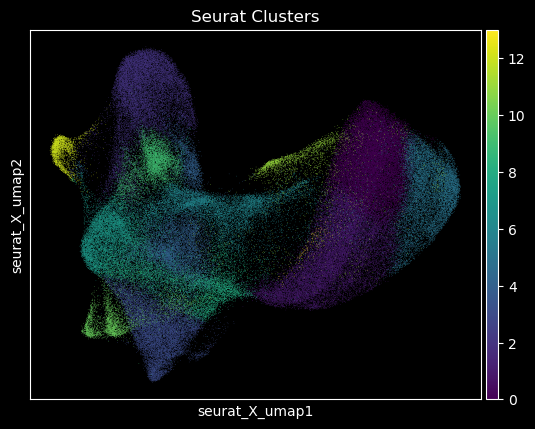

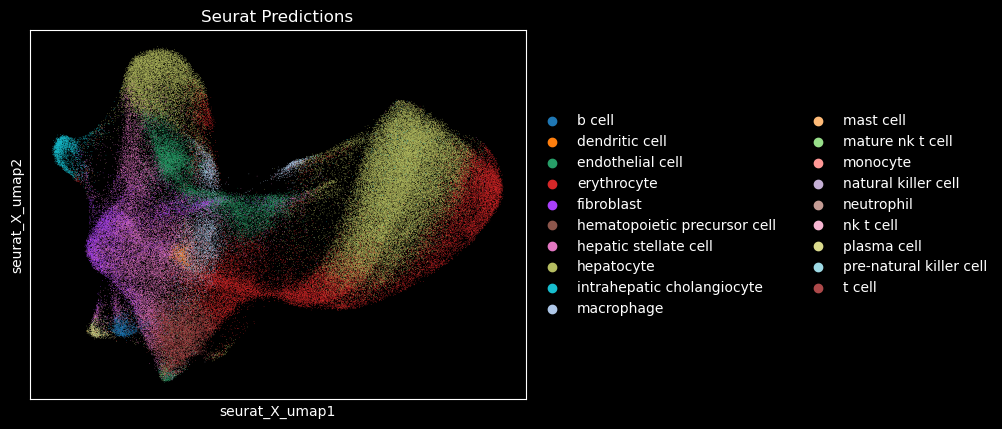

In [34]:
sc.pl.embedding(xenium_obj, basis='seurat_X_umap', color='seurat_clusters', title='Seurat Clusters', legend_loc='on data')
sc.pl.embedding(xenium_obj, basis='seurat_X_umap', color='seurat_predictions', title='Seurat Predictions')

In [35]:
#Finally we save the results for future analysis.
xenium_obj.write('liver_cancer.h5ad')